# AIPI 590 - XAI | Assignment #3
### Using Interpretable models i.e Linear Regression, logistic regression and GAN for understanding the factors that contribute to customer churn
### Ritu Toshniwal


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ritu1412/Interpretable-ML/blob/main/telecom_churn_analysis.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Interpretable-ML" 
git_path = 'https://github.com/ritu1412/Interpretable-ML.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = '.'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from pygam import LogisticGAM, s, f
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import learning_curve
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Loading and Preparation

Dataset link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [2]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [37]:
df.shape

(7043, 21)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
print(df['TotalCharges'].unique())

['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


In [6]:
# Convert TotalCharges which is a string to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
print(df['TotalCharges'].unique())

[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]


In [8]:
print(df['TotalCharges'].isnull().sum())

11


In [9]:
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_66477/2840544469.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


### Removing unnecessary columns

In [10]:
df.drop('customerID', axis=1, inplace=True)

### Handling duplicates

In [11]:
# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 22


In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7021.000000,7021.000000,7021.000000,7021.000000
mean,0.162512,32.469449,64.851894,2288.954490
std,0.368947,24.534965,30.069001,2265.319449
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.750000,411.150000
50%,0.000000,29.000000,70.400000,1400.550000
75%,0.000000,55.000000,89.900000,3801.700000
max,1.000000,72.000000,118.750000,8684.800000


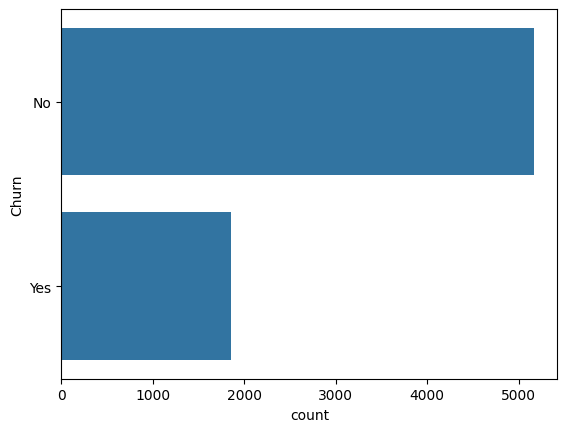

In [14]:
#plotting the distribution of the target variable
sns.countplot(df['Churn'])
plt.show()

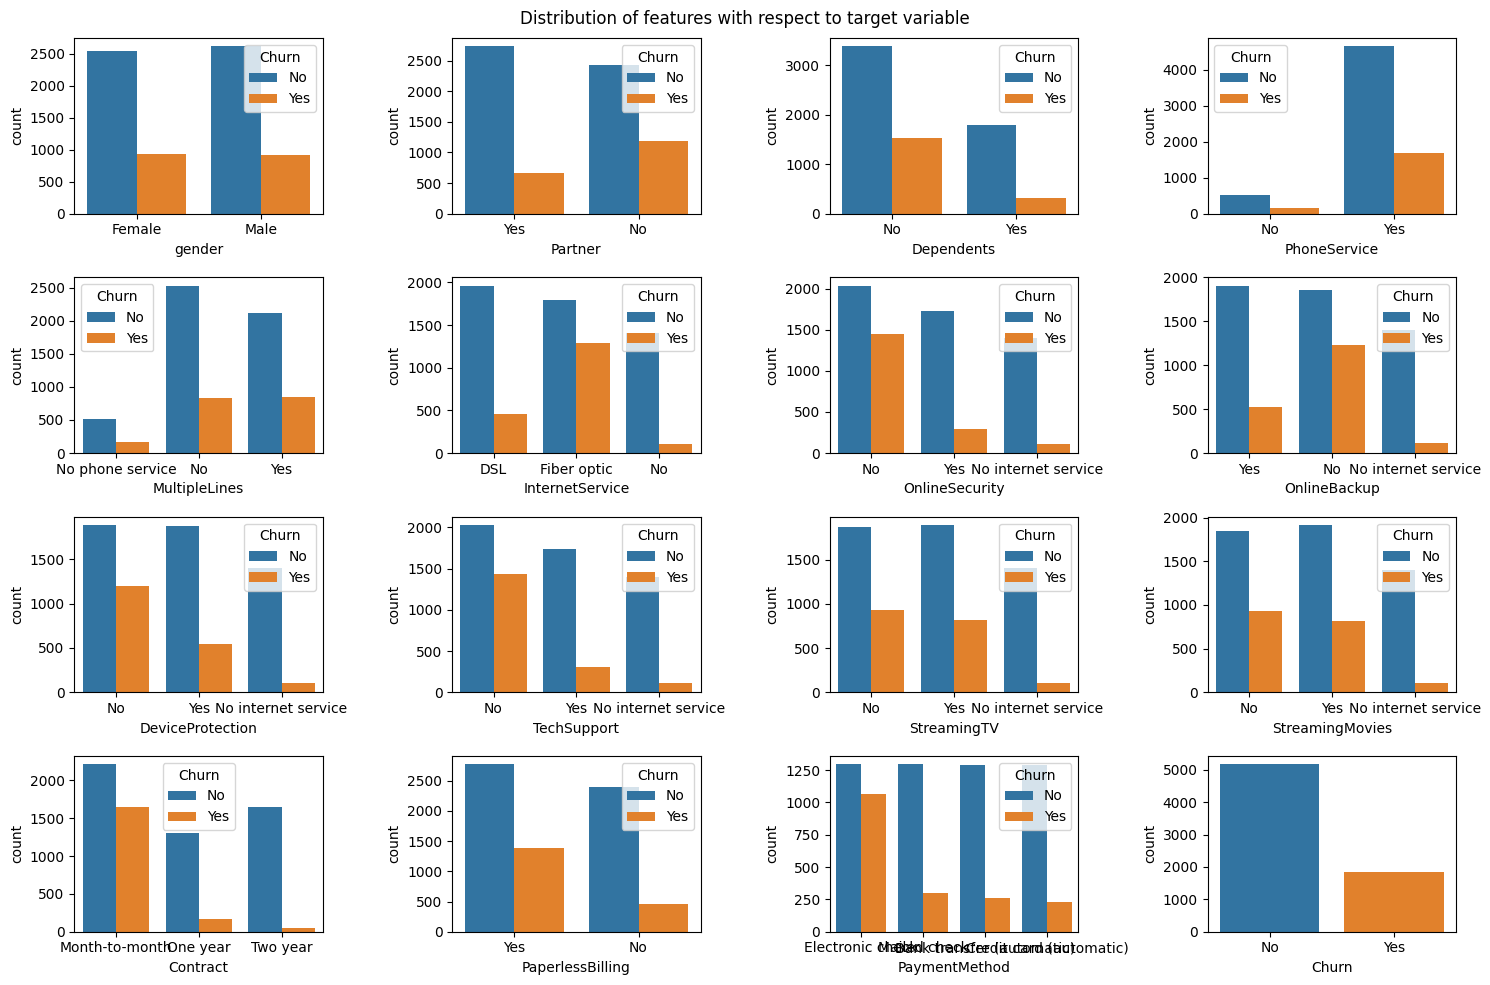

In [15]:
#Plot of the distribution of the target variable with respect to the categorical features
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
fig.suptitle('Distribution of features with respect to target variable')
sns.countplot
for ax, feature in zip(axes.flatten(), df.select_dtypes('object').columns):
    sns.countplot(x=feature, data=df, hue='Churn', ax=ax)
plt.tight_layout()
plt.show()


The distribution plots show that certain features, such as **Contract type**, **OnlineSecurity**, and **TechSupport**, have a significant influence on customer churn, with higher churn rates for customers with month-to-month contracts and no security or tech support. On the other hand, Phone services tend to have lower churn rates. These visualizations highlight key features that could help predict churn more effectively.

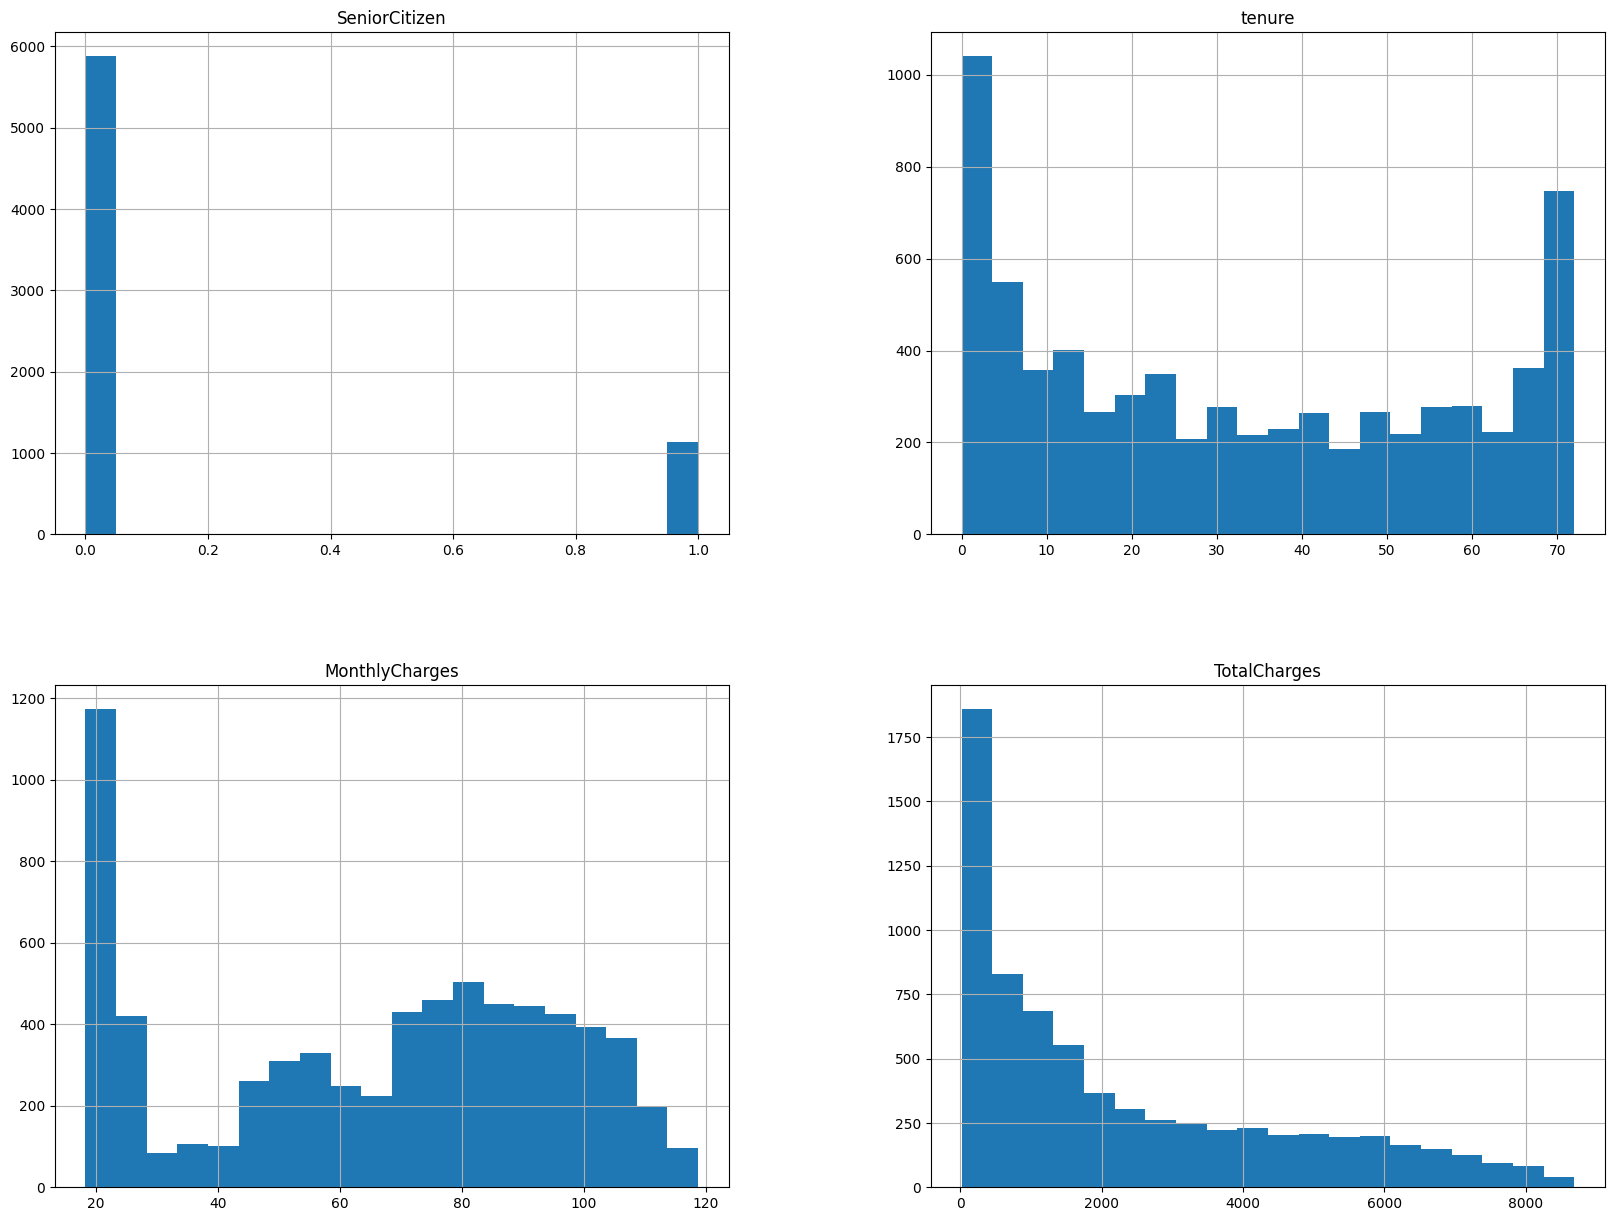

In [16]:
df.hist(bins=20, figsize=(20, 15))
plt.show()

The histograms display the distribution of key continuous variables in the dataset:

1. **SeniorCitizen**: Most customers are not senior citizens, with a small percentage falling into the senior category.
2. **Tenure**: There is a clear divide between customers who have just started their service and those who have been with the company for a long time, suggesting tenure influences churn.
3. **MonthlyCharges**: The distribution is fairly spread, indicating a wide range of monthly charges, with a peak around lower to mid-tier pricing.
4. **TotalCharges**: Skewed heavily towards lower total charges, with many customers having relatively small total charges, reflecting newer customers.

This indicates that **tenure** and **charges** likely play significant roles in churn prediction.

# Encoding the continuous variables

In [17]:
# Encode the target variable (Churn) to binary (0 for No, 1 for Yes)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [18]:
# Function to process binary columns (replace Yes/No with 1/0)
def process_column(column):
    column = column.replace(["No internet service", "No phone service"], "No")
    column = column.replace("Yes", "1")
    column = column.replace("No", "0")
    return pd.to_numeric(column, errors='coerce')

# Columns that are binary (Yes/No or No internet/phone service)
columns = ["Partner", "Dependents","OnlineSecurity", "OnlineBackup", 
           "DeviceProtection", "TechSupport", "StreamingTV", 
           "PaperlessBilling", "Churn","StreamingMovies","PhoneService"]

# Apply the process_column function to these binary columns
for column in columns:
    df[column] = process_column(df[column])

# Columns that need label encoding
categorical_columns = ["MultipleLines", "Contract", "PaymentMethod", "InternetService","gender"]

# Initialize label encoder
labelencoder = LabelEncoder()

# Apply label encoding to the categorical columns
for column in categorical_columns:
    df[column] = labelencoder.fit_transform(df[column])

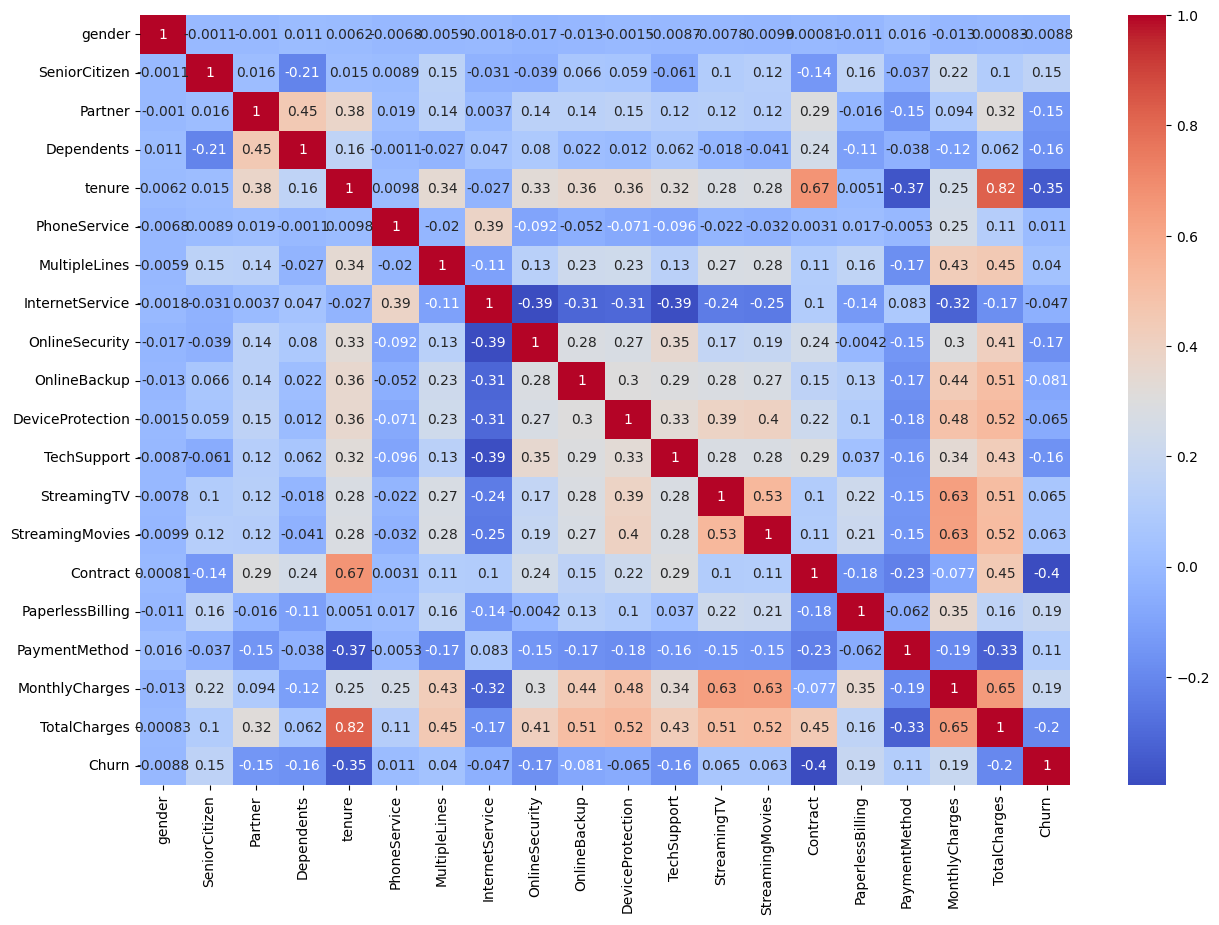

In [19]:
#heatmap to show the correlation between the features
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [20]:
#removing unwanted columns based on the above plots
df.drop(['gender', 'StreamingMovies','PhoneService'], axis=1, inplace=True)

In [21]:
df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,1,0,0,1,0,0,0,0,1,2,29.85,29.85,0
1,0,0,0,34,0,0,1,0,1,0,0,1,0,3,56.95,1889.50,0
2,0,0,0,2,0,0,1,1,0,0,0,0,1,3,53.85,108.15,1
3,0,0,0,45,1,0,1,0,1,1,0,1,0,0,42.30,1840.75,0
4,0,0,0,2,0,1,0,0,0,0,0,0,1,2,70.70,151.65,1


# Linear Regression

In [22]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize the StandardScaler and scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
#VIF (Multicollinearity Check)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
print("Variance Inflation Factors (VIF) for Multicollinearity Check:\n", vif_data)

Variance Inflation Factors (VIF) for Multicollinearity Check:
              Feature        VIF
0      SeniorCitizen   1.138857
1            Partner   1.451190
2         Dependents   1.382471
3             tenure   7.207219
4      MultipleLines   1.365500
5    InternetService   1.595960
6     OnlineSecurity   1.476187
7       OnlineBackup   1.480119
8   DeviceProtection   1.565799
9        TechSupport   1.529754
10       StreamingTV   1.788041
11          Contract   2.352906
12  PaperlessBilling   1.206788
13     PaymentMethod   1.175760
14    MonthlyCharges   4.599322
15      TotalCharges  10.416122


The VIF for TotalCharges is well above 10, indicating serious multicollinearity with other features, particularly with tenure and MonthlyCharges. This suggests that TotalCharges is highly correlated with other features, especially since it is often a direct function of tenure and MonthlyCharges (i.e., TotalCharges = tenure * MonthlyCharges).

In [24]:
X = df.drop(['TotalCharges','Churn'], axis=1)
# Remove the features with high VIF
X_train = X_train.drop(['TotalCharges'], axis=1)
X_test = X_test.drop(['TotalCharges'], axis=1)

# Scale the features again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

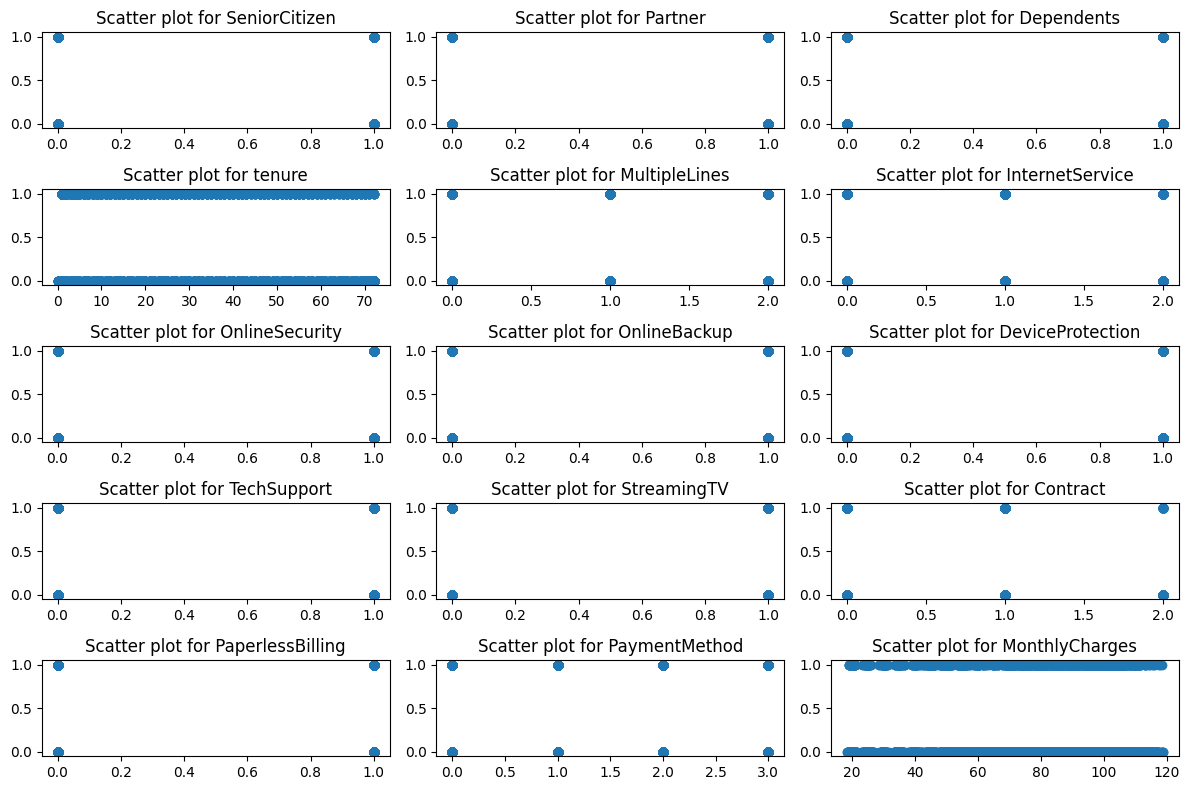

In [25]:
# Assumption check: Check for Linearity (Scatter Plots)
plt.figure(figsize=(12, 8))
n_rows = int(np.ceil(len(X.columns) / 3))

for i, col in enumerate(X.columns):
    plt.subplot(n_rows, 3, i + 1)  # Use integer n_rows
    plt.scatter(X[col], y)
    plt.title(f'Scatter plot for {col}')
    plt.tight_layout()
plt.show()

The assumption of linearity doesn't strictly apply here because these variables represent categories rather than continuous measurements.

In [26]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

In [27]:
r_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")


Linear Regression:
MSE: 0.14
R2 Score: 0.25
SeniorCitizen: 0.0248
Partner: 0.0032
Dependents: -0.0143
tenure: -0.1170
MultipleLines: 0.0206
InternetService: -0.0264
OnlineSecurity: -0.0489
OnlineBackup: -0.0310
DeviceProtection: -0.0182
TechSupport: -0.0505
StreamingTV: 0.0029
Contract: -0.0386
PaperlessBilling: 0.0240
PaymentMethod: 0.0053
MonthlyCharges: 0.1341


The R² score of 0.25 and MSE of 0.14 indicate that the linear regression model only explains about 25% of the variance in the target variable, suggesting a moderate fit.

Tenure and MonthlyCharges are the most influential features, with tenure negatively associated with churn (longer tenure reduces churn) and MonthlyCharges positively associated with churn (higher charges increase churn).
Features like OnlineSecurity, TechSupport, and Contract also have notable negative effects, meaning customers with these services or longer contracts are less likely to churn.
Other features like Partner, PaperlessBilling, and SeniorCitizen have smaller coefficients, indicating they have less influence on churn prediction.
Overall, while the model provides some insight into churn behavior, the relatively low R² suggests it may not fully capture the complexity of the relationships,

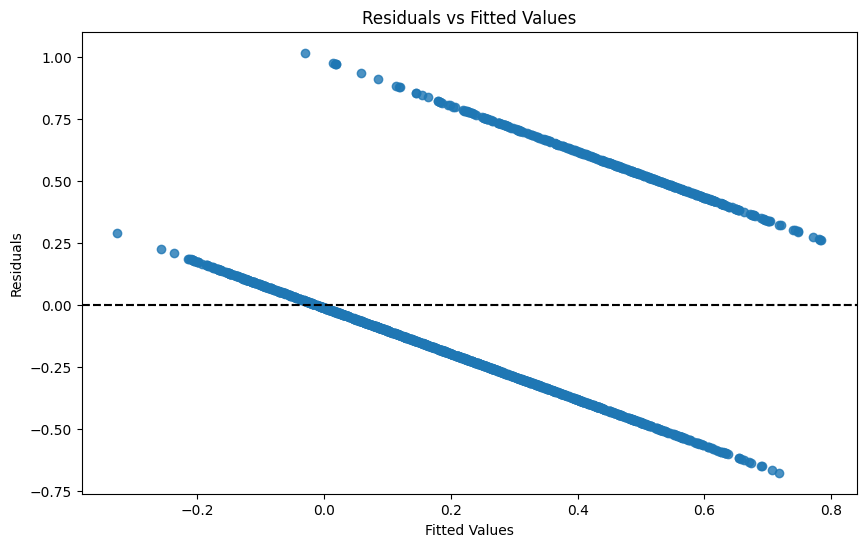

In [28]:
# Assumption check: Homoscedasticity (Residual Plot)
residuals = y_test - lr_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=lr_pred, y=residuals,  line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, linestyle='--', color='black')
plt.show()

The residuals exhibit a clear V-shaped pattern, which suggests that the model is not appropriately capturing the relationship between the features and the target variable. This type of pattern indicates that the errors are not distributed randomly, violating the assumption of homoscedasticity (constant variance of errors). The plot also suggests that a linear model might not be the best fit for this data. The distinct clustering of residuals above and below the fitted values indicates that there could be non-linear relationships in the data that the linear model is unable to capture

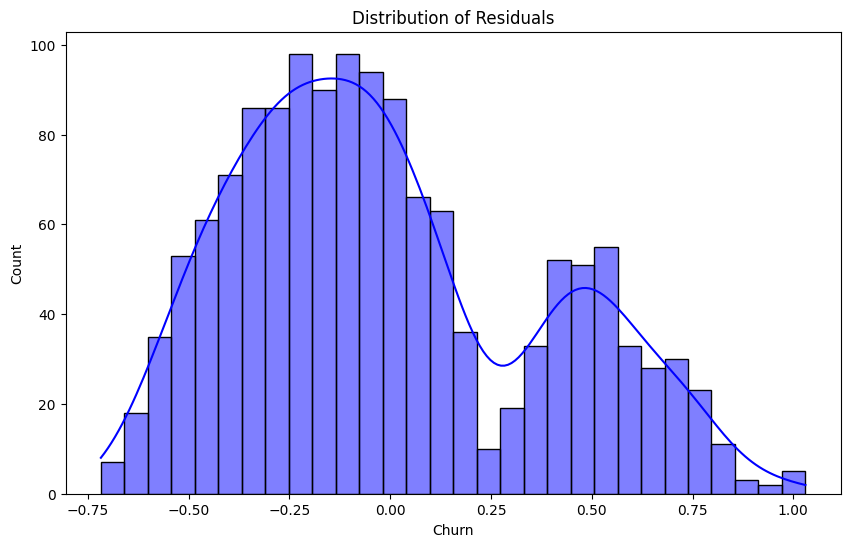

In [29]:
# Assumption check: Normality of Residuals (Histogram and Q-Q Plot)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Distribution of Residuals')
plt.show()

Linear regression assumes that residuals are normally distributed. This plot suggests that the assumption is violated, meaning the linear model may not be appropriate for this data.

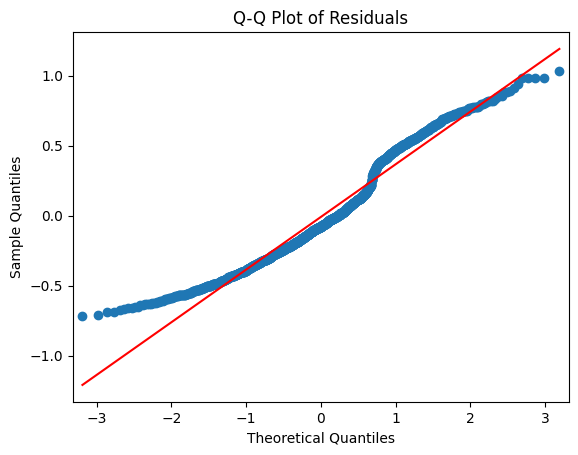

In [30]:
# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Trying Lasso model for regularisation

In [31]:
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")


Lasso Regression:
MSE: 0.17
R2 Score: 0.12
SeniorCitizen: 0.0000
Partner: -0.0000
Dependents: -0.0000
tenure: -0.0073
MultipleLines: 0.0000
InternetService: -0.0000
OnlineSecurity: -0.0000
OnlineBackup: -0.0000
DeviceProtection: -0.0000
TechSupport: -0.0000
StreamingTV: 0.0000
Contract: -0.0686
PaperlessBilling: 0.0000
PaymentMethod: 0.0000
MonthlyCharges: 0.0000


<Figure size 1200x600 with 0 Axes>

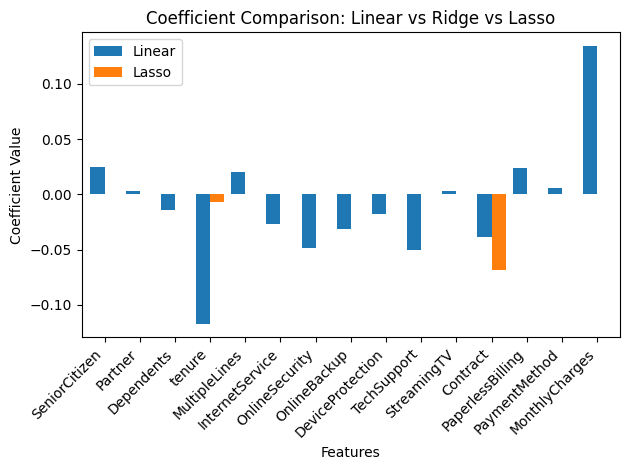

In [32]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model, lasso_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X.columns)

    plt.figure(figsize=(12, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(r_model, lasso_model)

Lasso Regression has shrunk certain coefficients (e.g., tenure, PaperlessBilling) to zero or near-zero, which suggests that these features may be less important than the Linear Regression model indicated.
MonthlyCharges is confirmed as a key driver of churn across both models, and it is less impacted by regularization, meaning it's a critical feature for predicting churn.

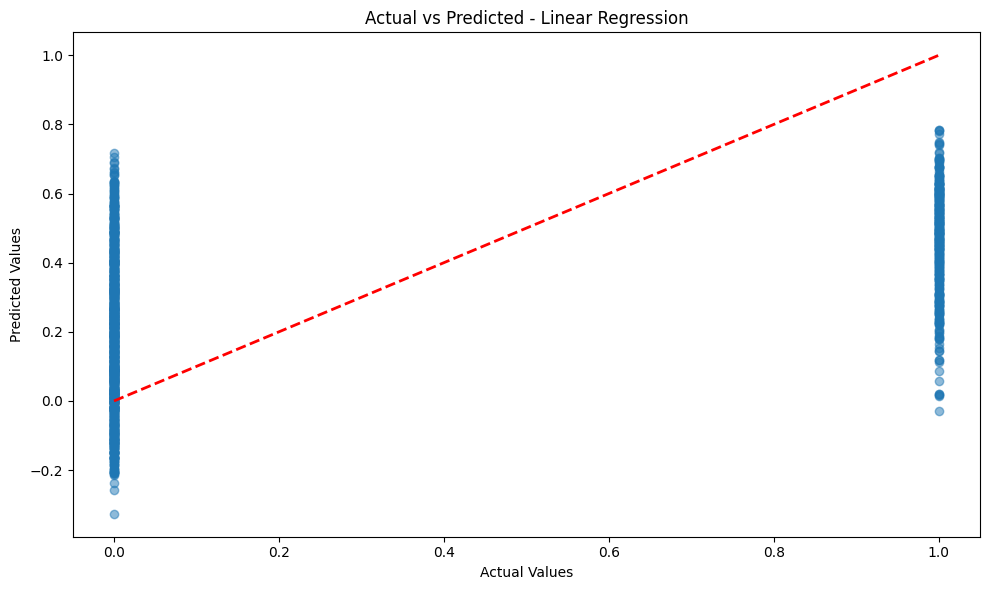

In [33]:
# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')

The plot shows that the model does reasonably well in distinguishing between churn and non-churn customers, as most predicted values are close to either 0 or 1.
However, there is a significant number of predicted values that fall between 0 and 1, which indicates that the model is not confident in its predictions for certain customers. This can lead to misclassification when converting these continuous predictions to binary outcomes.

# Logistic Regression

In [34]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict and evaluate logistic regression
y_pred_log = logistic_model.predict(X_test_scaled)
y_pred_log_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]

Optimization terminated successfully.
         Current function value: 0.424810
         Iterations 7


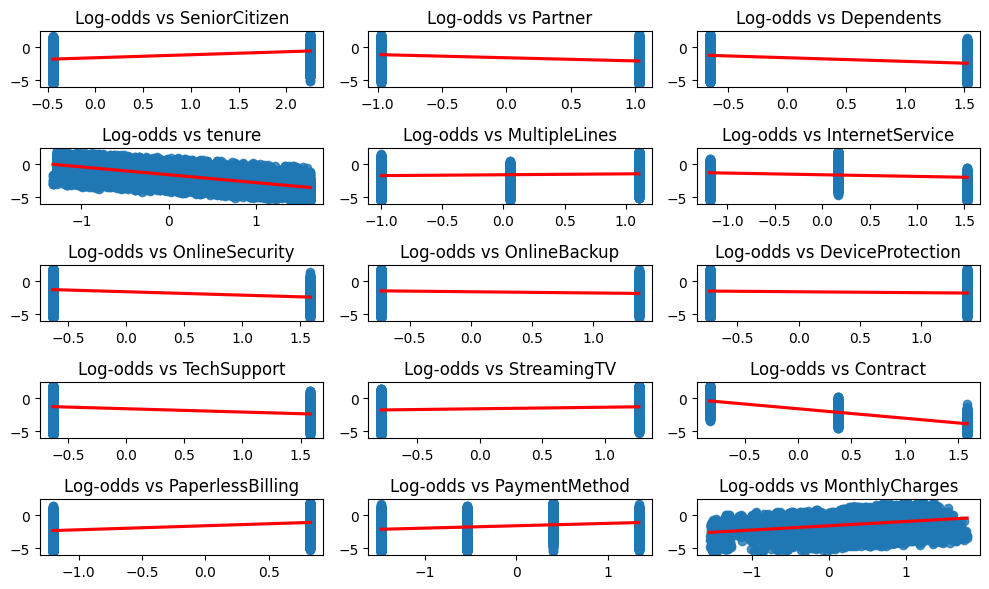

In [35]:
# Linearity of log-odds for continuous features
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled)).fit()

# Plot log-odds vs continuous features
fitted_values = logit_model.predict(sm.add_constant(X_train_scaled))
plt.figure(figsize=(10, 6))
n_rows = int(np.ceil(len(X.columns) / 3))
for i, column in enumerate(X.columns):
    plt.subplot(n_rows, 3, i + 1)
    sns.regplot(x=X_train_scaled[:, i], y=np.log(fitted_values / (1 - fitted_values)), line_kws={'color': 'red'})
    plt.title(f'Log-odds vs {column}')
    plt.tight_layout()
plt.show()

Features with Strong Effects: Tenure, Contract, and MonthlyCharges show the most pronounced relationships with log-odds, with tenure and contract decreasing the likelihood of churn and monthly charges increasing it. These features are crucial in predicting customer churn.

Features with Weaker Effects: Features such as SeniorCitizen, Partner, Dependents, MultipleLines, PaperlessBilling, and PaymentMethod have relatively flat lines, indicating that their effect on churn is less significant compared to other variables.

In [36]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logistic_model.coef_[0]
})
# Convert coefficients to odds ratios
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])
print("Logistic Regression Coefficients (Odds Ratios):")
print(coefficients)

Logistic Regression Coefficients (Odds Ratios):
             Feature  Coefficient  Odds Ratio
0      SeniorCitizen     0.121649    1.129358
1            Partner     0.027059    1.027429
2         Dependents    -0.115435    0.890978
3             tenure    -0.814935    0.442668
4      MultipleLines     0.137264    1.147131
5    InternetService    -0.161858    0.850562
6     OnlineSecurity    -0.270565    0.762949
7       OnlineBackup    -0.123215    0.884074
8   DeviceProtection    -0.051107    0.950177
9        TechSupport    -0.270192    0.763233
10       StreamingTV     0.064466    1.066589
11          Contract    -0.582723    0.558376
12  PaperlessBilling     0.163516    1.177645
13     PaymentMethod     0.061170    1.063080
14    MonthlyCharges     0.820460    2.271544


High Monthly Charges (Odds Ratio = 2.272) is the strongest predictor of churn, indicating that customers with higher bills are much more likely to leave.
Tenure (Odds Ratio = 0.443) significantly reduces churn, highlighting the importance of retaining customers over time.
Services like OnlineSecurity and TechSupport also play an important role in reducing churn, while paperless billing and multiple lines moderately increase the risk.

In [37]:
accuracy = accuracy_score(y_test, y_pred_log)
conf_matrix = confusion_matrix(y_test, y_pred_log)
roc_auc = roc_auc_score(y_test, y_pred_log_proba)
classification_rep = classification_report(y_test, y_pred_log)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"AUC-ROC: {roc_auc}")
print("\nClassification Report:")
print(classification_rep)


Model Performance Metrics:
Accuracy: 0.795017793594306
Confusion Matrix:
[[932 121]
 [167 185]]
AUC-ROC: 0.8414324872658207

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1053
           1       0.60      0.53      0.56       352

    accuracy                           0.80      1405
   macro avg       0.73      0.71      0.71      1405
weighted avg       0.79      0.80      0.79      1405



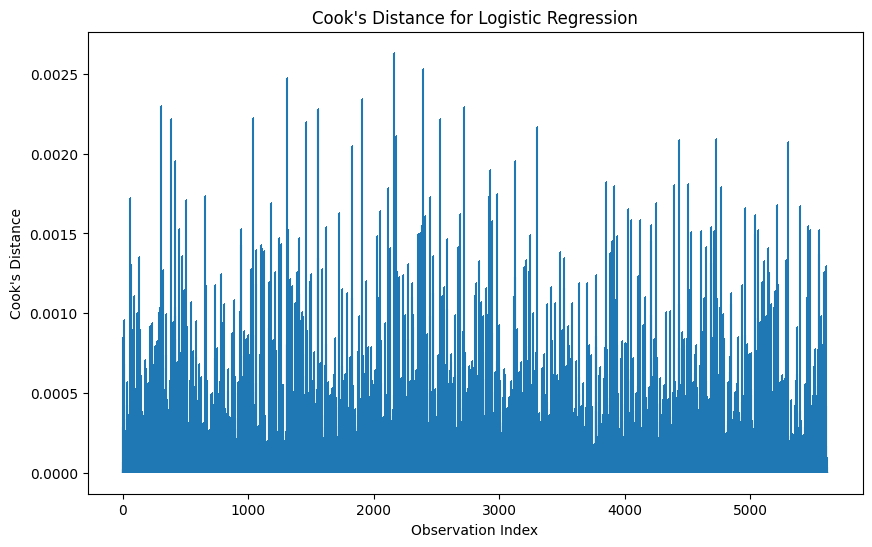

In [38]:
#Influence of Outliers
influence = logit_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.title("Cook's Distance for Logistic Regression")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()

Observations from the Plot:
Low Influence: From the plot, it is clear that none of the observations exceed Cook's Distance of 0.0025, which is very low compared to the threshold of 1.
No Significant Outliers: Since the highest Cook's Distance value in this plot is very small, it suggests that no single observation is overly influential on the model. The model's coefficients are not being significantly distorted by any particular data point.
Uniformity: The data points are fairly uniformly distributed, with no extreme spikes. This suggests that all data points are contributing similarly to the model, without any major outliers affecting the fit. Ref: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html

# GAN

In [39]:
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12)).fit(X_train_scaled, y_train)

# Predict and evaluate GAM
y_pred_gam = gam.predict(X_test_scaled)
y_pred_gam_proba = gam.predict_proba(X_test_scaled)

print("\nGeneralized Additive Model (GAM) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_gam))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_gam_proba))
print(classification_report(y_test, y_pred_gam))


Generalized Additive Model (GAM) Results:
Accuracy: 0.7921708185053381
AUC-ROC: 0.8472181753431753
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1053
           1       0.60      0.51      0.55       352

    accuracy                           0.79      1405
   macro avg       0.72      0.70      0.71      1405
weighted avg       0.78      0.79      0.79      1405



In [40]:
#coefficients of the GAM model for each feature
print("\nGAM Coefficients:")
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    print(f"{X.columns[i]}: {gam.coef_[i]:.4f}")


GAM Coefficients:
SeniorCitizen: -0.2141
Partner: -0.1972
Dependents: -0.1804
tenure: -0.1635
MultipleLines: -0.1467
InternetService: -0.1298
OnlineSecurity: -0.1130
OnlineBackup: -0.0961
DeviceProtection: -0.0793
TechSupport: -0.0624
StreamingTV: -0.0456
Contract: -0.0287
PaperlessBilling: -0.0119


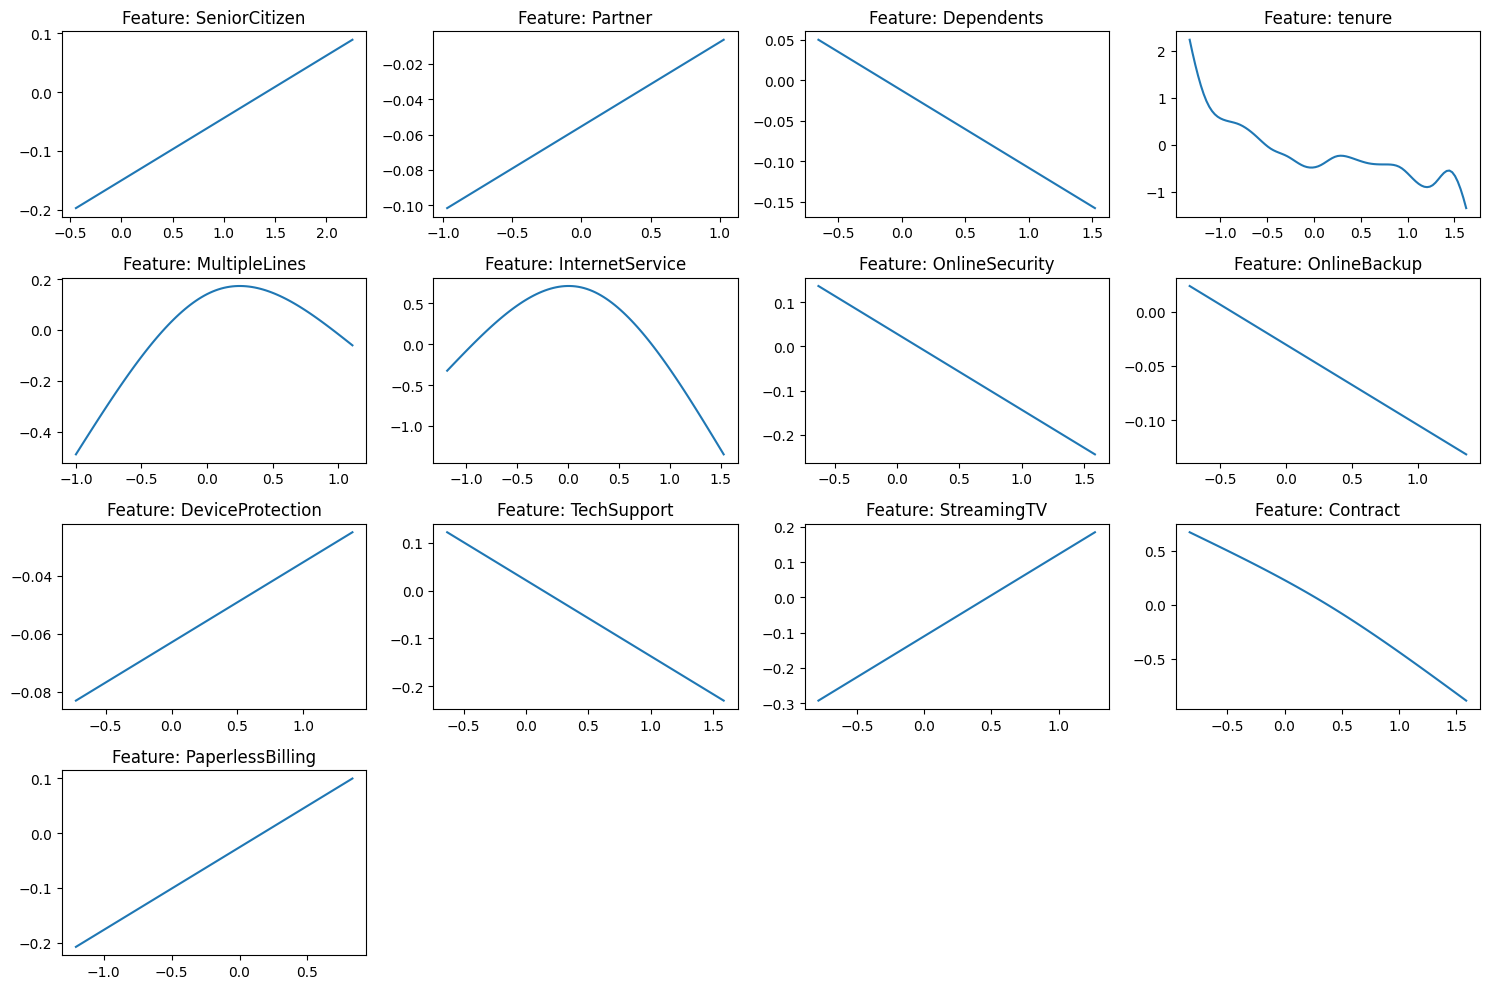

In [41]:
plt.figure(figsize=(15, 10))
# Iterate over the terms using indices
for i in range(len(gam.terms)):
    if gam.terms[i].isintercept:  # Skip intercept terms
        continue
    plt.subplot(4, 4, i + 1)
    XX = gam.generate_X_grid(term=i)  # Generate grid only for non-intercept terms
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Feature: {X.columns[i]}')
    plt.tight_layout()

plt.show()

Interpretation:
Positive slope (e.g., SeniorCitizen, Partner, PaperlessBilling): Indicates that as the feature increases (or when the value is present, as in binary features), it positively influences the predicted outcome—in this case, increasing the likelihood of churn.

Negative slope (e.g., Dependents, Contract): Suggests that an increase in the feature reduces the likelihood of churn.

Non-linear effects: For tenure, MultipleLines, and InternetService, the effects are more complex. These features influence the prediction in a non-linear way, meaning the impact of these features changes at different levels, often peaking at mid-level values.

In [42]:
# Fit your GAM model and obtain residuals
residuals = y_test - gam.predict(X_test_scaled)

# Perform the Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson Test: {dw_test}")

Durbin-Watson Test: 2.017123287671233


Value near 2 indicates there is no significant autocorrelation in the residuals. Ref: https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html

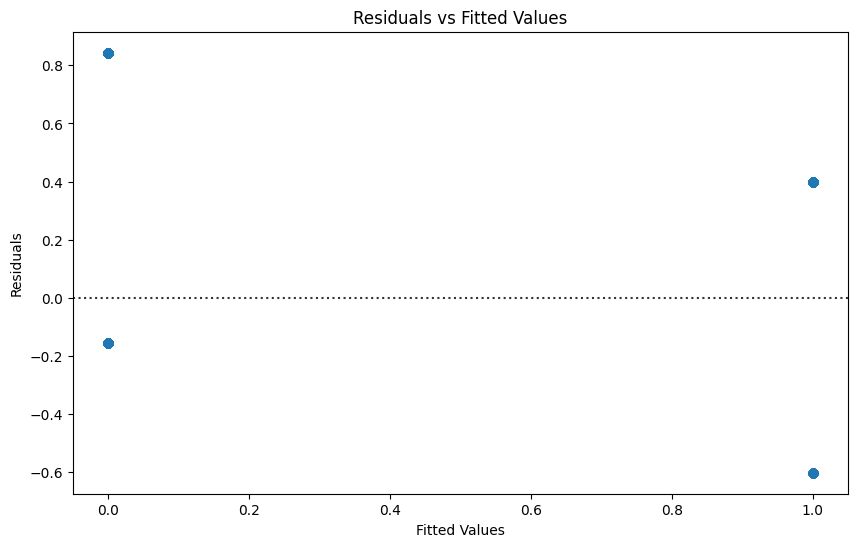

In [43]:

# Plot Residuals vs Fitted Values
plt.figure(figsize=(10, 6))
sns.residplot(x=gam.predict(X_test_scaled), y=residuals, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

This above plot confirms that the model is behaving as expected for a binary classification problem.
And there is no obvious pattern of residulas, which is a good sign for Homoscedasticity

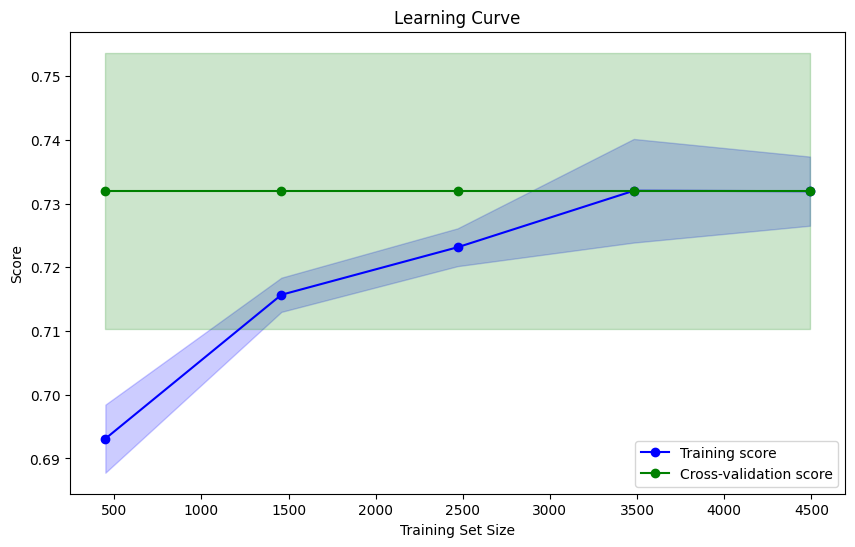

In [44]:
train_sizes, train_scores, test_scores = learning_curve(gam, X_train_scaled, y_train, cv=5, n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

# Calculating mean and std for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

# Plotting standard deviation for train and test scores
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

From the learning curve, it seems like the dataset is large enough, as increasing the training set size does not lead to significant improvements in cross-validation performance. The model appears to be learning effectively with the available data

| **Model**               | **Performance**                                      | **Interpretability**                                                                                                           | **Strengths**                                                                                     | **Weaknesses**                                                                                     |
|-------------------------|------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Linear Regression**    | - MSE: 0.14<br> - R2 Score: 0.25 (low predictive power) | - Coefficients indicate linear relationships, e.g., **MonthlyCharges** and **MultipleLines** increase churn probability.<br> - Not suitable for binary classification problems like churn. | - Simple and easy to interpret.<br> - Coefficients show direct linear relationships.               | - Poor performance for binary classification.<br> - Violates assumptions of linearity and normality.<br> - Low R2 score. |
| **Logistic Regression**  | - Accuracy: 79.5%<br> - AUC-ROC: 0.84                | - Coefficients can be interpreted as **odds ratios**.<br> - E.g., **tenure** and **Contract** significantly reduce churn risk. | - Suitable for binary classification.<br> - Interpretable with odds ratios.<br> - Good overall performance (AUC-ROC, accuracy). | - Does not capture non-linear relationships.<br> - Moderate recall for churn prediction (0.53).   |
| **Generalized Additive Model (GAM)** | - Accuracy: 79.2%<br> - AUC-ROC: 0.85     | - Captures **non-linear relationships** between features and churn.<br> - E.g., **tenure** has a non-linear effect on churn, shown in partial dependence plots. | - Captures complex non-linear relationships.<br> - Slightly better AUC-ROC than logistic regression. | - Less interpretable compared to logistic regression.<br> - More complex to implement and understand. |


### Recommendations:

- **Logistic Regression** is a strong contender for this problem, balancing performance and interpretability. It provides good accuracy and AUC-ROC, with interpretable coefficients that give actionable insights for the telecommunications company (e.g., focusing on reducing churn by offering longer-term contracts or better service for high-paying customers).
  
- **GAM** is recommended if the company wants to capture more **non-linear relationships** and is willing to sacrifice some interpretability for potentially better modeling of complex features.

- **Linear Regression** should not be used due to its poor fit for a binary classification problem and low predictive power. It's only useful for understanding simple relationships but does not provide competitive accuracy or interpretability for churn prediction.

Overall, **Logistic Regression** is the best choice for **interpretability and ease of implementation**